## Light interception with Caribu

In progress ...  

We have to configure Caribu to simulate the same light as in STICS

In [1]:
## Imports
import math
import numpy as np
from random import *
import matplotlib.pyplot as plt

from oawidgets.plantgl import *
from openalea.plantgl.all import Material, Color3, Shape, Scene, Viewer, Translated, AxisRotated
from alinea.astk import *

from openalea.archicrop.cereals import build_shoot
from openalea.archicrop.display import build_scene, display_scene
from openalea.archicrop.simulation import retrieve_stics_dynamics_from_file, generate_and_display_plant, dict_ranges_to_all_possible_combinations
from openalea.archicrop.archicrop import ArchiCrop
from openalea.archicrop.plant_shape import compute_leaf_area_growing_plant, compute_height_growing_plant

# Enable plotting with PlantGL
%gui qt

# Set nice color for plants
nice_green=Color3((50,100,0))

## Retrieve STICS dynamics from file 

In [2]:
stics_output_file = 'mod_ssorghum.sti'
sowing_density = 10
inter_row = 0.4
stics_output_data = retrieve_stics_dynamics_from_file(stics_output_file, sowing_density)
height_potential_plant = max(value["Plant height"] for value in stics_output_data.values())
time = [value["Thermal time"] for value in stics_output_data.values()]
# print(height_potential_plant)
# print(stics_output_data)

## Pseudo-intercrop scene

In [3]:
## Imports

# Fix a seed
seed(1)

## Code for generating an intercrop from descritive parameters

def plant(height, nb_phy, max_leaf_length, wl, phyllotactic_angle):
    """ return the MTG of a cereal shoot generative from descriptive parameters """

    shoot, g = build_shoot(nb_phy=nb_phy,
                            height=height,
                            max_leaf_length=max_leaf_length,
                            wl=wl, diam_base=2.5, diam_top=1.0, 
                            insertion_angle=30, scurv=0.6, curvature=120, 
                            alpha=-2.3, stem_q=1, rmax=0.67, skew=0.05,
                            phyllotactic_angle=phyllotactic_angle,
                            phyllotactic_deviation=20)
    
    return g


# Organize the plant mixture in alternate rows
n_rows = 6 # 10
len_rows = 10

d_inter = 70
d_intra = 70

def plant_in_row(i):
     if i%(4*d_inter)==0 or i%(4*d_inter)==d_inter: return plant(height=300, nb_phy=26, max_leaf_length=80, wl=0.12, phyllotactic_angle=180)
     # if i%(2*d_inter)==0: return plant(height=1700, nb_phy=18, max_leaf_length=100, wl=0.12, phyllotactic_angle=180)
     else: return plant(height=150, nb_phy=15, max_leaf_length=40, wl=0.7, phyllotactic_angle=60)


plants_in_intercrop = [plant_in_row(x) for x in range(0, n_rows*d_inter, d_inter) for y in range(0, len_rows*d_intra, d_intra)]

positions=[(x,y,0) for x in range(0, n_rows*d_inter, d_inter) for y in range(0, len_rows*d_intra, d_intra)]

# Build and display scene
scene_ic, nump = build_scene(plants_in_intercrop, positions, leaf_material=Material(nice_green), stem_material=Material(nice_green))
# display_scene(scene_ic)
PlantGL(scene_ic)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

## Vary parameters one by one

In [4]:
def generate_single_list_dicts(params):
    """
    Generate dictionaries where only one parameter remains a list and all others are single values.
    
    :param params: dict - The input dictionary containing parameters.
    :return: list of dict - A list of dictionaries with only one parameter as a list.
    """
    single_list_dicts = []

    for key, value in params.items():
        if isinstance(value, list):  # Only consider keys with list values
            # Create a base dictionary with single values
            base_dict = {k: (v[0] if isinstance(v, list) else v) for k, v in params.items()}
            # Replace the single value with the original list for the current key
            base_dict[key] = value
            # Add the dictionary to the results
            single_list_dicts.append(base_dict)
    
    return single_list_dicts

## Vary chosen architectural parameters (and developmental parameters ?) and select the sets of parameters that make the model fit

In [23]:

############ in function ###############

# Parameter distribution in Latin Hypercube
from random import *
from scipy.stats import qmc

seed(100)

# Define parameter bounds
# For sorghum
archi_params = dict(
    nb_phy = [10,40], # [10,15,20,25,30], 
    max_leaf_length = [40,120], 
    wl = [0.1,0.12], 
    diam_base = 2.2, 
    diam_top = 1.5, 
    insertion_angle = 30, # [10, 50], 
    scurv = 0.7, # [0.6, 0.8], 
    curvature = 90, # [35, 130], 
    alpha = -2.3, 
    stem_q = [1.01,1.25], 
    rmax = [0.7,0.8,0.9], # 1-(1/3*(nb_phy - 5)/nb_phy)
    skew = [0.01, 0.1], # 0.08 # 0.0005
    phyllotactic_angle = 180, 
    phyllotactic_deviation = 15, # [5, 30]
    phyllochron = [40,65],
    plastochron = [34,46],
    leaf_duration = [1,8],
    stem_duration = [1,8],
    leaf_senescence = [500, 900]
)

# def to_list(d):
#     return {k: (v if isinstance(v, list) else [v]) for k,v in d.items()} 

# archi_params = to_list(archi_params)

l_bounds = []
u_bounds = []
for k,v in archi_params.items():
    if isinstance(v, list):
        l_bounds.append(v[0])
        u_bounds.append(v[-1])

# Number of samples to generate
n_samples = 500

# Create a Latin Hypercube sampler
sampler = qmc.LatinHypercube(d=len(l_bounds))  # d = number of parameters

# Generate normalized samples (0 to 1)
lhs_samples = sampler.random(n=n_samples)

# Scale samples to parameter bounds
scaled_samples = qmc.scale(lhs_samples, l_bounds=l_bounds, u_bounds=u_bounds)

# Int for scaled samples
for s in scaled_samples:
    s[0] = int(s[0])

# Use scaled_samples to evaluate your model
# print("Sampled Parameters:")
# for s in scaled_samples:
#     print(s)

2


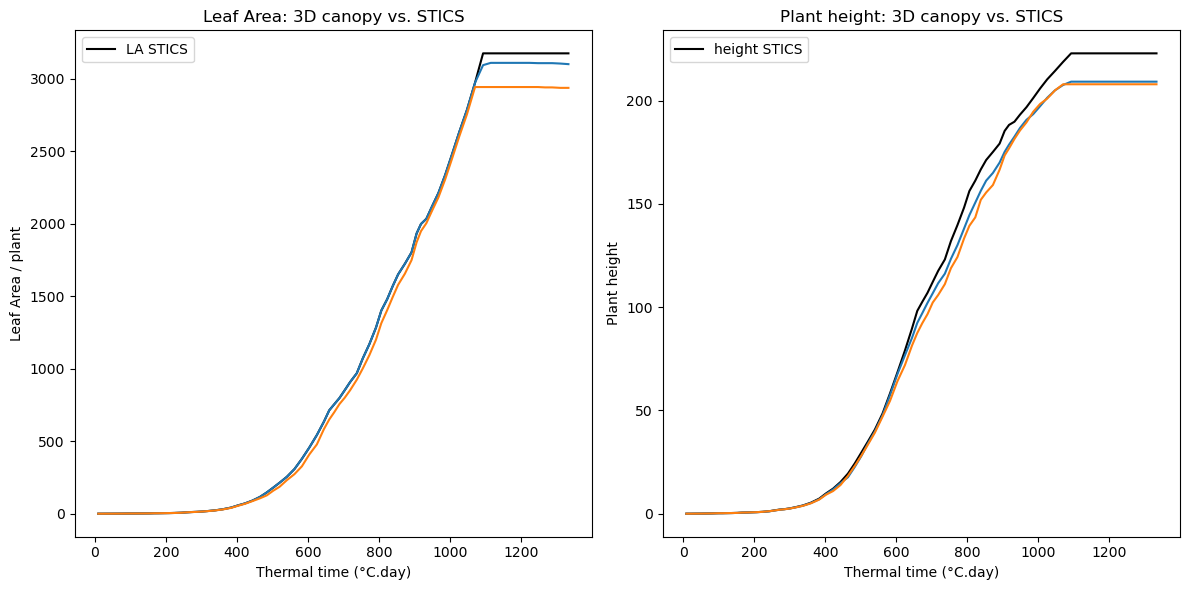

In [8]:

########## in function ####################

# Evaluate the closeness of the model to the LAI curve of the crop model 
LA_stics = [value["Plant leaf area"] for value in stics_output_data.values()]
height_stics = [value["Plant height"] for value in stics_output_data.values()]

mtg_good_plants = []
results_LA = []
results_height = []
good_params = []

error_LA = 300 # cm²
error_height = 30 # cm


for params in scaled_samples:
    sorghum = ArchiCrop(height=height_potential_plant, # from crop model
                        nb_phy=int(params[0]),
                        max_leaf_length=params[1],
                        wl=params[2], 
                        diam_base=2.2, 
                        diam_top=1.2, 
                        insertion_angle=30, # to vary for light interception
                        scurv=0.7, # to vary for light interception
                        curvature=90, # to vary for light interception
                        alpha=-2.3, 
                        stem_q=params[3], # to vary to fit height dynamics
                        rmax=params[4], 
                        skew=params[5], 
                        phyllotactic_angle=180,
                        phyllotactic_deviation=15, # to vary for light interception
                        phyllochron = params[6],
                        plastochron = params[7],
                        leaf_duration = params[8],
                        stem_duration = params[9],
                        leaf_senescence = params[10])
    g = sorghum.generate_potential_plant()
    g = sorghum.define_development(g)
    growing_plant = sorghum.grow_plant(g, stics_output_data)

    LA_archicrop = [sum(compute_leaf_area_growing_plant(gp)) for gp in growing_plant] 
    height_archicrop = [compute_height_growing_plant(gp) for gp in growing_plant]
    # --> properties in MTG at plant scale

    good = True
    for i,(la,h) in enumerate(zip(LA_archicrop, height_archicrop)):
        if LA_stics[i]-error_LA <= la <= LA_stics[i]+error_LA and height_stics[i]-error_height <= h <= height_stics[i]+error_height: 
            good = True
        else:
            good = False
            break
    if good:
        mtg_good_plants.append(growing_plant)
        results_LA.append(LA_archicrop)
        results_height.append(height_archicrop)
        good_params.append(params)


print(len(results_LA))

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot on the first subplot
axes[0].plot(time, LA_stics, color="black", label="LA STICS")
for result in results_LA:
    axes[0].plot(time, result)
axes[0].set_xlabel("Thermal time (°C.day)")
axes[0].set_ylabel("Leaf Area / plant")
axes[0].set_title("Leaf Area: 3D canopy vs. STICS")
axes[0].legend()

# Plot on the second subplot
axes[1].plot(time, height_stics, color="black", label="height STICS")
for result in results_height:
    axes[1].plot(time, result)
axes[1].set_xlabel("Thermal time (°C.day)")
axes[1].set_ylabel("Plant height")
axes[1].set_title("Plant height: 3D canopy vs. STICS")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [9]:
good_params

[array([2.20000000e+01, 5.73331282e+01, 1.12306323e-01, 1.01972475e+00,
        7.16543714e-01, 8.47795712e-02, 4.37558133e+01, 4.52136827e+01,
        5.73149746e+00, 7.61198635e+00, 9.91476180e+02]),
 array([2.00000000e+01, 9.78115544e+01, 1.07752267e-01, 1.03740367e+00,
        8.72545040e-01, 5.41342405e-02, 4.88360334e+01, 4.33598147e+01,
        5.47840100e+00, 5.10246557e+00, 9.96403264e+02])]

In [25]:
# Convert to a NumPy array for easier manipulation
parameters = np.array(good_params)

# Calculate min and max for each parameter
min_values = np.min(parameters, axis=0)
max_values = np.max(parameters, axis=0)

# Display results
# print("Min values:", [float(v) for v in min_values])
# print("Max values:", [float(v) for v in max_values])

i = 0
for k,v in archi_params.items():
    if isinstance(v, list):
        archi_params[k] = [min_values[i], max_values[i]]
        print(k, ':', [round(v,3) for v in archi_params[k]])
        i += 1

def to_list(d):
    return {k: (v if isinstance(v, list) else [v]) for k,v in d.items()} 

archi_params = to_list(archi_params)

nb_phy : [20.0, 22.0]
max_leaf_length : [57.333, 97.812]
wl : [0.108, 0.112]
stem_q : [1.02, 1.037]
rmax : [0.717, 0.873]
skew : [0.054, 0.085]
phyllochron : [43.756, 48.836]
plastochron : [43.36, 45.214]
leaf_duration : [5.478, 5.731]
stem_duration : [5.102, 7.612]
leaf_senescence : [991.476, 996.403]


In [11]:

################# in function ##################

# Visualize the plants with these parameters

from ipywidgets import interact, interactive, IntSlider, FloatSlider, fixed, Play, HBox, VBox, jslink

# Fix a seed
seed(100)
nice_green = Color3((50, 100, 0))

# slider on parameters with ranges, others fixed 

height=height_potential_plant
nb_phy_slider=IntSlider(min=min(archi_params["nb_phy"]), max=max(archi_params["nb_phy"]), step=1, value=15, description="Nb of phytomers")
max_leaf_length_slider=IntSlider(min=min(archi_params["max_leaf_length"]), max=max(archi_params["max_leaf_length"]), step=1, value=50, description="Length of longest leaf")
wl_slider=FloatSlider(min=min(archi_params["wl"]), max=max(archi_params["wl"]), step=0.01, value=0.12)
diam_base_slider=fixed(archi_params["diam_base"][0])
diam_top_slider=fixed(archi_params["diam_top"][0])
insertion_angle_slider=IntSlider(min=min(archi_params["insertion_angle"]), max=max(archi_params["insertion_angle"]), step=1, value=30)
scurv_slider=FloatSlider(min=min(archi_params["scurv"]), max=max(archi_params["scurv"]), step=0.01, value=0.7)
curvature_slider=IntSlider(min=min(archi_params["curvature"]), max=max(archi_params["curvature"]), step=5, value=90)
alpha_slider=fixed(archi_params["alpha"][0])
stem_q_slider=fixed(archi_params["stem_q"][0])
rmax_slider=FloatSlider(min=min(archi_params["rmax"]), max=max(archi_params["rmax"]), step=0.01, value=0.8)
skew_slider=fixed(archi_params["skew"][0])
phyllotactic_angle_slider=fixed(archi_params["phyllotactic_angle"][0])
phyllotactic_deviation_slider=IntSlider(min=min(archi_params["phyllotactic_deviation"]), max=max(archi_params["phyllotactic_deviation"]), step=5, value=15)
phyllochron_slider=IntSlider(min=min(archi_params["phyllochron"]), max=max(archi_params["phyllochron"]), step=1, value=55)
plastochron_slider=IntSlider(min=min(archi_params["plastochron"]), max=max(archi_params["plastochron"]), step=1, value=40)
leaf_duration_slider=FloatSlider(min=min(archi_params["leaf_duration"]), max=max(archi_params["leaf_duration"]), step=0.1, value=3)
stem_duration_slider=FloatSlider(min=min(archi_params["stem_duration"]), max=max(archi_params["stem_duration"]), step=0.1, value=2)
leaf_senescence_slider=IntSlider(min=min(archi_params["leaf_senescence"]), max=max(archi_params["leaf_senescence"]), step=10, value=800)

time_slider = IntSlider(value=0, min=0, max=len(time), step=1, description="Time")

# Interactive widget setup
play_widget = Play(value=0, min=0, max=len(time), step=1, interval=1000)

# Link play widget with time slider
jslink((play_widget, 'value'), (time_slider, 'value'))

# Callback to update scene
def update_scene(*args):
    seed(100)
    sorghum = ArchiCrop(height, nb_phy_slider.value, max_leaf_length_slider.value, wl_slider.value, 
                        diam_base_slider.value, diam_top_slider.value, insertion_angle_slider.value, scurv_slider.value, 
                        curvature_slider.value, alpha_slider.value, stem_q_slider.value, rmax_slider.value, skew_slider.value, 
                        phyllotactic_angle_slider.value, phyllotactic_deviation_slider.value, 
                        phyllochron_slider.value, plastochron_slider.value, leaf_duration_slider.value, 
                        stem_duration_slider.value, leaf_senescence_slider.value)
    g = sorghum.generate_potential_plant()
    g = sorghum.define_development(g)
    growing_plant = sorghum.grow_plant(g, stics_output_data)
    Viewer.display(build_scene(growing_plant[time_slider.value], leaf_material = Material(nice_green), stem_material=Material(nice_green))[0])

# Attach update callback
nb_phy_slider.observe(update_scene, names='value')
max_leaf_length_slider.observe(update_scene, names='value')
# insertion_angle_slider.observe(update_scene, names='value')
# scurv_slider.observe(update_scene, names='value')
# curvature_slider.observe(update_scene, names='value')
time_slider.observe(update_scene, names='value')

# Display widgets
controls = VBox([nb_phy_slider, max_leaf_length_slider, insertion_angle_slider, scurv_slider, curvature_slider, HBox([time_slider, play_widget])])
display(controls)

# Initial scene display
update_scene()

# cf github openalea weberpenn trunk_parameters

In [12]:
# # Calculate covariance matrix
# covariance_matrix = np.cov(parameters, rowvar=False)

# # Calculate correlation matrix
# correlation_matrix = np.corrcoef(parameters, rowvar=False)

# # Display results
# print("Covariance matrix:\n", covariance_matrix)
# print("Correlation matrix:\n", correlation_matrix)

In [13]:
# from sklearn.decomposition import PCA

# # Perform PCA
# pca = PCA()
# pca.fit(parameters)

# # Principal components and explained variance
# print("Principal components:\n", pca.components_)
# print("Explained variance ratio:", pca.explained_variance_ratio_)

In [14]:
# from sklearn.cluster import KMeans

# # Perform clustering
# num_clusters = 2  # Adjust as needed
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# clusters = kmeans.fit_predict(parameters)

# # Add cluster labels to parameter sets
# print("Cluster labels:", clusters)

In [15]:
# import pandas as pd
# import seaborn as sns

# # Heatmap of correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Parameter Correlation Matrix")
# plt.show()

## Stand

In [17]:
scene = sorghum.display_stand(g, sowing_density=sowing_density, length_plot=1, width_plot=1, inter_row=0.4)

PlantGL(scene)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

## Compute PAR intercepted

In [ ]:
        # if i > 0:
        #     # stand
        #     scene, nump = build_scene(plants, positions, leaf_material=Material(nice_green), stem_material=Material(nice_green))
        #     # compute light inter
        #     values = compute_light_inter(scene)
        #     par_crop = sum(values)*0.0145
        #     # print(par_crop)
        #     par_caribu.append(par_crop)

In [ ]:
archi_params_combinations = dict_ranges_to_all_possible_combinations(archi_params)

par_caribu = []
par_stics = []

for archi in archi_params_combinations:
    caribu, stics = model_with_light_inter(*archi,
                                            sowing_density=sowing_density, 
                                            inter_row=inter_row,
                                            filename_outputs=filename_outputs)
    par_caribu.append(caribu)
par_stics = stics

In [ ]:
# Convert to a NumPy array for easier manipulation
curves = par_caribu_dens_10
curves_array = np.array(curves)

# Calculate the envelope: min and max values for each time point
min_values = curves_array.min(axis=0)
max_values = curves_array.max(axis=0)

# Plotting the envelope along with individual curves for context
time_points = time
for curve in curves:
    plt.plot(time_points, curve, alpha=0.5, linestyle='--')  # Plot each curve (optional for visualization)

plt.fill_between(time_points, min_values, max_values, color="skyblue", alpha=0.4)
plt.plot(time_points, min_values, color="blue", linestyle="--", label="Min 3D")
plt.plot(time_points, max_values, color="red", linestyle="--", label="Max 3D")
plt.plot(time_points, par, color="black", label="STICS")
plt.scatter(time_points, LA_stics)

# Labels and legend
plt.xlabel("Thermal time")
plt.ylabel("PAR intercepted")
plt.title("PAR intercepted: 3D canopy vs. STICS")
plt.legend()
plt.show()

## Compute Beer-Lambert light extinction coefficient at each time step

### Light interception in STICS

The radiation intercepted by the crop $raint$ is expressed according to a Beer’s law function of $lai$. The $extinP$ parameter is a daily extinction coefficient and $parsurrgG$ is a climatic parameter corresponding to the ratio (in radiative energy) of photosynthetically active radiation to the global radiation $trg(t)$ (around 0.48, Varlet-Grancher et al. (1982)). 

$$raint(t)=0.95*parsurrgG*trg(t)*(1−exp^{−extinP*(lai(t)+eai(t))})$$

$$extinP = - \frac{1}{lai(t)+eai(t)} ln(1 - \frac{raint(t)}{0.95*parsurrgG*trg(t)})$$

$$extinP = - \frac{1}{lai(t)+eai(t)} ln(1 - ratio\_par\_abs)$$

In [ ]:
# Compute coef extinP

extinP_list = []

for par_time_series in par_caribu:
    extinP_per_sim = []
    for i,par in enumerate(par_time_series):
        if par < 1:
            lai = la_cum[i+2]*sowing_density/1000
            extinP = -1/lai * math.log(1-par)
        else:
            extinP = 0
        extinP_per_sim.append(extinP)
    extinP_list.append(extinP_per_sim)

time_points = tt_cum[1:]
for curve in extinP_list:
    plt.plot(time_points, curve, alpha=0.5, linestyle='-')
plt.show()

In [ ]:
# courbe parameters beer-lambert --> analysis of decomposition of uncertainty, parametric

## Next steps

- Configure Caribu to mimic what happens in STICS' 2.5D formalism, cf https://vezy.github.io/STICS-IC-paper/
- Simulations to run with IFB Cloud